# Detailed (EDA) for Pharmaceutical Manufacturing Time Series Data

This notebook performs a comprehensive exploratory data analysis on pharmaceutical manufacturing process data to prepare it for time series forecasting. The dataset contains 25 different manufacturing process files (1.csv to 25.csv) representing different production campaigns/batches. 

## Dataset Description
Based on the dataset documentation and initial exploration, this is a pharmaceutical manufacturing dataset containing:
- **Time Series Data**: Each file contains timestamped process measurements at 10-second intervals
- **Process Parameters**: Various manufacturing process variables including speeds, pressures, temperatures, and material flows
- **Production Metrics**: Output measures like production counts, waste, and quality indicators
- **Multiple Campaigns**: 25 different manufacturing campaigns/batches for comparative analysis

## Objective
The primary goal is to perform EDA to:
1. Understand the structure and characteristics of the time series data
2. Identify patterns, trends, and anomalies in the manufacturing process
3. Assess data quality and preprocessing requirements
4. Prepare the data for forecasting models to predict production outcomes
5. Extract insights for process optimization



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import glob

In [5]:
# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Data Loading and Initial Exploration

Loading and examining the structure of our pharmaceutical manufacturing datasets.


In [6]:
data_dir = '/kaggle/input/process-eda-dataset/Process'

# Get list of all CSV files
csv_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])
print(f"Found {len(csv_files)} CSV files:")
print(csv_files[:10], "..." if len(csv_files) > 10 else "")


Found 25 CSV files:
['1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '16.csv', '17.csv', '18.csv'] ...


In [7]:
# Load a sample file to understand the structure
sample_file = os.path.join(data_dir, csv_files[0])
print(f"\nExamining structure of: {csv_files[0]}")

# Load sample data
sample_df = pd.read_csv(sample_file, sep=';')
print(f"\nDataset shape: {sample_df.shape}")
print(f"Columns: {list(sample_df.columns)}")
print("\nFirst 5 rows:")
print(sample_df.head())

print("\nData types:")
print(sample_df.dtypes)

print("\nBasic statistics:")
print(sample_df.describe())


Examining structure of: 1.csv

Dataset shape: (106878, 16)
Columns: ['timestamp', 'campaign', 'batch', 'code', 'tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']

First 5 rows:
             timestamp  campaign  batch  code  tbl_speed  fom  main_comp  \
0  2018-11-22 23:07:27         4     26     1        0.0  0.0        0.2   
1  2018-11-22 23:07:37         4     26     1        0.0  0.0        0.2   
2  2018-11-22 23:07:47         4     26     1        0.0  0.0        0.2   
3  2018-11-22 23:07:57         4     26     1        0.0  0.0        0.2   
4  2018-11-22 23:08:07         4     26     1        0.0  0.0        0.2   

   tbl_fill  SREL  pre_comp  produced  waste  cyl_main  cyl_pre  stiffness  \
0      4.09   0.0       0.0       0.0    0.0      1.06      4.0        3.0   
1      4.09   0.0       0.0       0.0    0.0      1.06      4.0        3.0   
2      4.09   0.0       0.0       0.0    0.0    

### Variable Definitions and Understanding

Based on the data structure, let's define what each variable represents in the pharmaceutical manufacturing process:

**Categorical Variables:**
- `timestamp`: Date and time of measurement (10-second intervals)
- `campaign`: Manufacturing campaign identifier
- `batch`: Batch number within campaign
- `code`: Process code identifier

**Process Control Variables:**
- `tbl_speed`: Table/conveyor speed (manufacturing line speed)
- `fom`: Feed rate or flow measurement
- `main_comp`: Main component concentration/measurement
- `tbl_fill`: Table fill level
- `SREL`: Special relative measurement (possibly pressure or flow)
- `pre_comp`: Pre-compression measurement

**Output/Performance Variables:**
- `produced`: Number of units produced
- `waste`: Amount of waste generated
- `cyl_main`: Main cylinder measurement
- `cyl_pre`: Pre-compression cylinder measurement
- `stiffness`: Material stiffness measurement
- `ejection`: Ejection force measurement

This appears to be tablet manufacturing data where each row represents a 10-second measurement during the production process.


In [8]:
# Load and examine all files for comprehensive analysis
def load_all_datasets():
    all_data = []
    file_info = []
    
    for file in csv_files:
        file_path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(file_path, sep=';')
            # Convert timestamp to datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            # Add file identifier
            df['file_id'] = int(file.split('.')[0])
            
            all_data.append(df)
            
            # Collect file statistics
            file_info.append({
                'file': file,
                'file_id': int(file.split('.')[0]),
                'rows': len(df),
                'start_time': df['timestamp'].min(),
                'end_time': df['timestamp'].max(),
                'duration_hours': (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600,
                'campaigns': df['campaign'].unique(),
                'batches': df['batch'].unique()
            })
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    file_info_df = pd.DataFrame(file_info)
    
    return combined_df, file_info_df

combined_data, file_summary = load_all_datasets()

Error loading 13.csv: month must be in 1..12: 07052019 20:14, at position 0
Error loading 15.csv: month must be in 1..12: 22112018 00:18, at position 0
Error loading 17.csv: month must be in 1..12: 07052019 14:09, at position 0
Error loading 23.csv: month must be in 1..12: 12052018 09:28, at position 0


In [9]:
print(f"\nCombined dataset shape: {combined_data.shape}")
print(f"Date range: {combined_data['timestamp'].min()} to {combined_data['timestamp'].max()}")
print(f"Total duration: {(combined_data['timestamp'].max() - combined_data['timestamp'].min()).days} days")


Combined dataset shape: (1717175, 17)
Date range: 2018-05-12 00:22:52 to 2020-08-06 12:47:44
Total duration: 817 days


In [10]:
print("\nFile summary:")
print(file_summary[['file', 'rows', 'duration_hours', 'campaigns', 'batches']].head(10))


File summary:
     file    rows  duration_hours                      campaigns  \
0   1.csv  106878     8078.612500    [4, 8, 31, 65, 66, 67, 109]   
1  10.csv  101306    13041.318333  [13, 26, 46, 60, 78, 87, 100]   
2  11.csv   49264     6480.170833  [22, 38, 64, 75, 95, 97, 112]   
3  12.csv  176044     8030.883056   [15, 27, 47, 63, 76, 84, 98]   
4  14.csv  249320     8275.660556      [11, 30, 55, 73, 96, 101]   
5  16.csv   55171     6733.785000                      [21, 105]   
6  18.csv    6596       18.319444                           [24]   
7  19.csv   18502      312.802222                       [32, 36]   
8   2.csv  160513     6288.446944         [5, 9, 41, 42, 68, 69]   
9  20.csv   18132     7010.410556                      [18, 108]   

                                             batches  
0  [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...  
1  [64, 65, 66, 67, 68, 69, 150, 151, 152, 184, 1...  
2  [83, 84, 85, 86, 87, 149, 260, 261, 332, 411, ...  
3  [62, 63, 142,

## 2. Data Quality Assesment

In [11]:
# 1. Missing Values Analysis
print("Missing Values:")
missing_counts = combined_data.isnull().sum()
missing_percentages = (missing_counts / len(combined_data)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])


Missing Values:
           Missing_Count  Missing_Percentage
cyl_pre             1370            0.079782
produced            1370            0.079782
cyl_main            1220            0.071047
ejection            1121            0.065282
tbl_fill            1110            0.064641
pre_comp            1074            0.062545
main_comp           1074            0.062545
SREL                1074            0.062545
stiffness           1074            0.062545
waste               1073            0.062486
tbl_speed           1073            0.062486
fom                 1073            0.062486


In [12]:
# 2. Duplicate Records
print(f"Duplicate Records:")
duplicates = combined_data.duplicated().sum()
print(f"Total duplicates: {duplicates}")


Duplicate Records:
Total duplicates: 360


In [13]:
# 3. Data Types Check
print(f"Data Types:")
print(combined_data.dtypes)

Data Types:
timestamp    datetime64[ns]
campaign              int64
batch                 int64
code                  int64
tbl_speed           float64
fom                 float64
main_comp           float64
tbl_fill            float64
SREL                float64
pre_comp            float64
produced            float64
waste               float64
cyl_main            float64
cyl_pre             float64
stiffness           float64
ejection            float64
file_id               int64
dtype: object


In [14]:
# 4. Unique Value Counts for Categorical Variables
print(f"Unique Values in Categorical Columns:")
categorical_cols = ['campaign', 'batch', 'code', 'file_id']
for col in categorical_cols:
    print(f"{col}: {combined_data[col].nunique()} unique values")
    print(f"  Values: {sorted(combined_data[col].unique())}")


Unique Values in Categorical Columns:
campaign: 93 unique values
  Values: [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 94, 95, 96, 97, 98, 99, 100, 101, 105, 107, 108, 109, 112, 114, 117, 119, 130, 131, 135]
batch: 416 unique values
  Values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 1

In [15]:
# 5. Basic Statistical Summary
print(f"Statistical Summary:")
numeric_cols = combined_data.select_dtypes(include=[np.number]).columns
print(combined_data[numeric_cols].describe())

Statistical Summary:
           campaign         batch          code     tbl_speed           fom  \
count  1.717175e+06  1.717175e+06  1.717175e+06  1.716102e+06  1.716102e+06   
mean   6.106576e+01  2.629978e+02  1.273383e+01  7.519013e+01  3.590389e+01   
std    3.232254e+01  1.510769e+02  7.596603e+00  5.320159e+01  3.260724e+01   
min    3.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
25%    3.400000e+01  1.230000e+02  6.000000e+00  0.000000e+00  0.000000e+00   
50%    6.100000e+01  2.520000e+02  1.200000e+01  1.000000e+02  3.000000e+01   
75%    8.700000e+01  3.680000e+02  2.100000e+01  1.200000e+02  6.000000e+01   
max    1.350000e+02  6.690000e+02  2.500000e+01  2.000000e+02  1.200000e+02   

          main_comp      tbl_fill          SREL      pre_comp      produced  \
count  1.716101e+06  1.716065e+06  1.716101e+06  1.716101e+06  1.715805e+06   
mean   6.258380e+00  5.112717e+00  4.878995e+00  1.006335e+00  9.527160e+02   
std    2.344959e+00  1.322560e

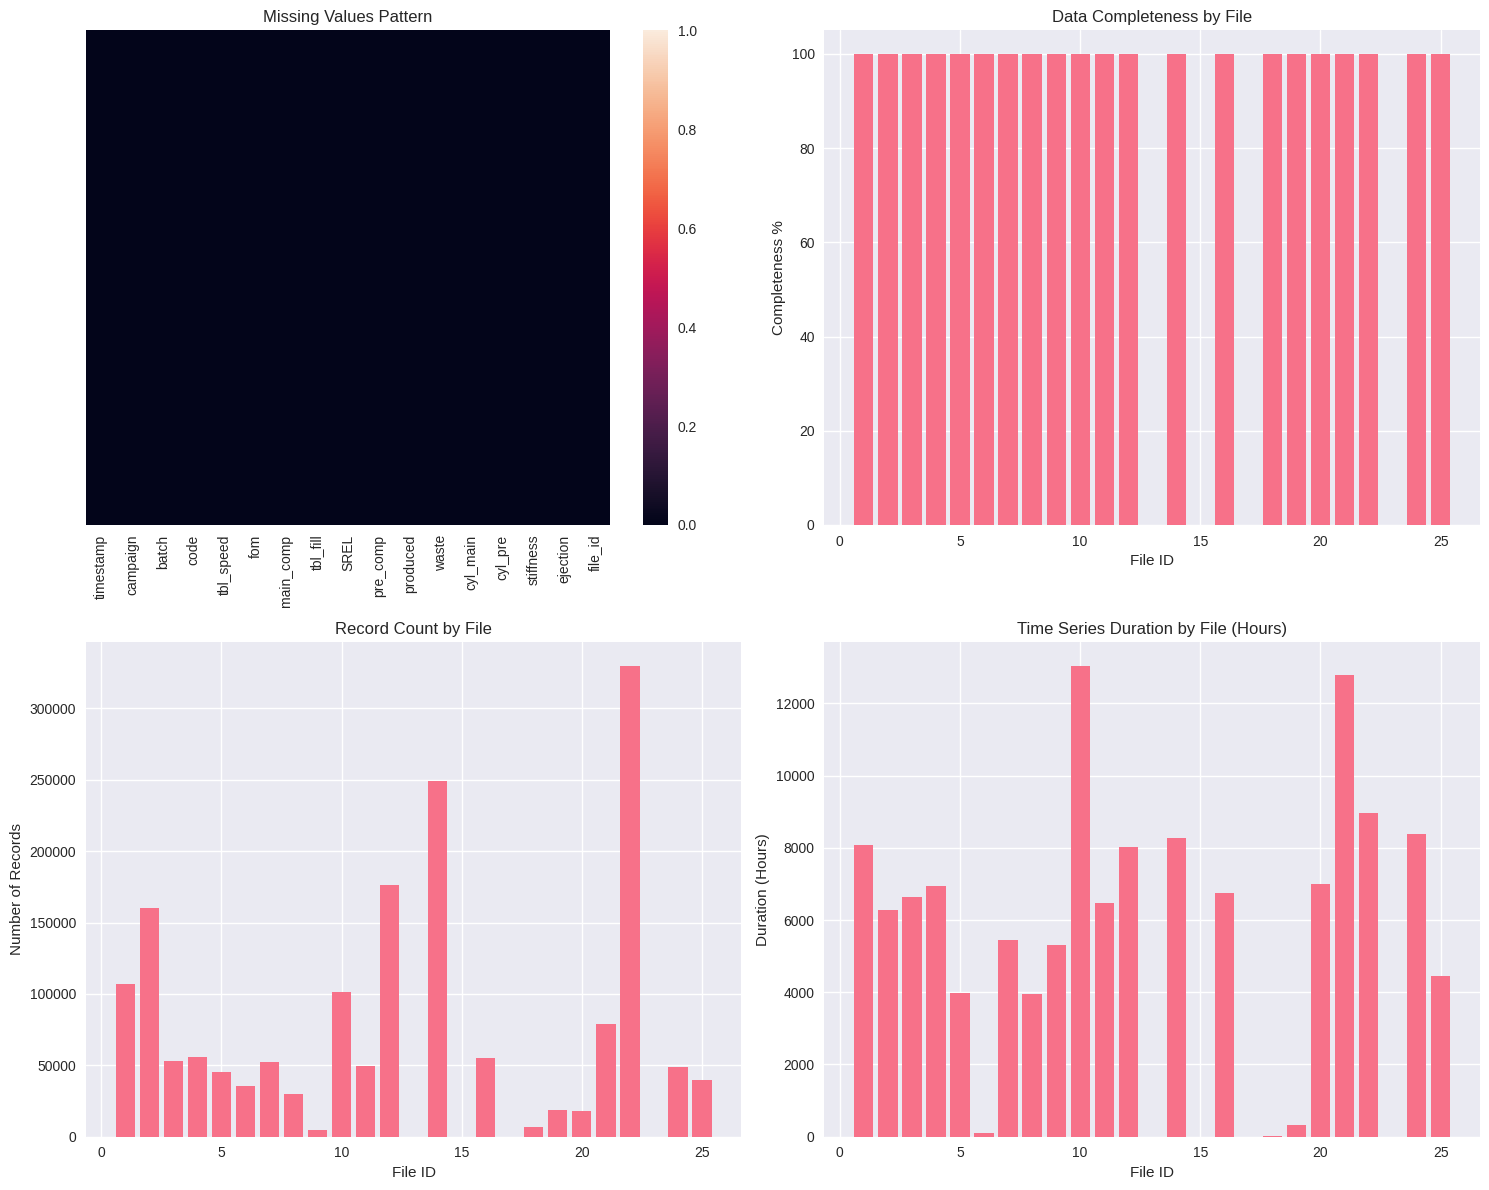

In [16]:
# Visualize data quality issues
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Missing values heatmap
if missing_df['Missing_Count'].sum() > 0:
    sns.heatmap(combined_data.isnull(), ax=axes[0,0], cbar=True, yticklabels=False)
    axes[0,0].set_title('Missing Values Pattern')
else:
    axes[0,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center')
    axes[0,0].set_title('Missing Values Pattern')

# 2. Data completeness by file
file_completeness = []
for file_id in sorted(combined_data['file_id'].unique()):
    file_data = combined_data[combined_data['file_id'] == file_id]
    completeness = (1 - file_data.isnull().sum().sum() / (len(file_data) * len(file_data.columns))) * 100
    file_completeness.append({'file_id': file_id, 'completeness': completeness})

completeness_df = pd.DataFrame(file_completeness)
axes[0,1].bar(completeness_df['file_id'], completeness_df['completeness'])
axes[0,1].set_title('Data Completeness by File')
axes[0,1].set_xlabel('File ID')
axes[0,1].set_ylabel('Completeness %')

# 3. Record count distribution
file_counts = combined_data['file_id'].value_counts().sort_index()
axes[1,0].bar(file_counts.index, file_counts.values)
axes[1,0].set_title('Record Count by File')
axes[1,0].set_xlabel('File ID')
axes[1,0].set_ylabel('Number of Records')

# 4. Time series coverage
time_coverage = combined_data.groupby('file_id')['timestamp'].agg(['min', 'max'])
time_coverage['duration'] = (time_coverage['max'] - time_coverage['min']).dt.total_seconds() / 3600
axes[1,1].bar(time_coverage.index, time_coverage['duration'])
axes[1,1].set_title('Time Series Duration by File (Hours)')
axes[1,1].set_xlabel('File ID')
axes[1,1].set_ylabel('Duration (Hours)')

plt.tight_layout()
plt.show()

In [17]:
print(f"Data Quality Summary:")
print(f"- Total records: {len(combined_data):,}")
print(f"- Missing values: {combined_data.isnull().sum().sum():,}")
print(f"- Duplicate records: {duplicates:,}")
print(f"- Data completeness: {((1 - combined_data.isnull().sum().sum() / (len(combined_data) * len(combined_data.columns))) * 100):.2f}%")


Data Quality Summary:
- Total records: 1,717,175
- Missing values: 13,706
- Duplicate records: 360
- Data completeness: 99.95%


## 3. Time Series Analysis and Patterns

Analyze the temporal patterns in our manufacturing data.


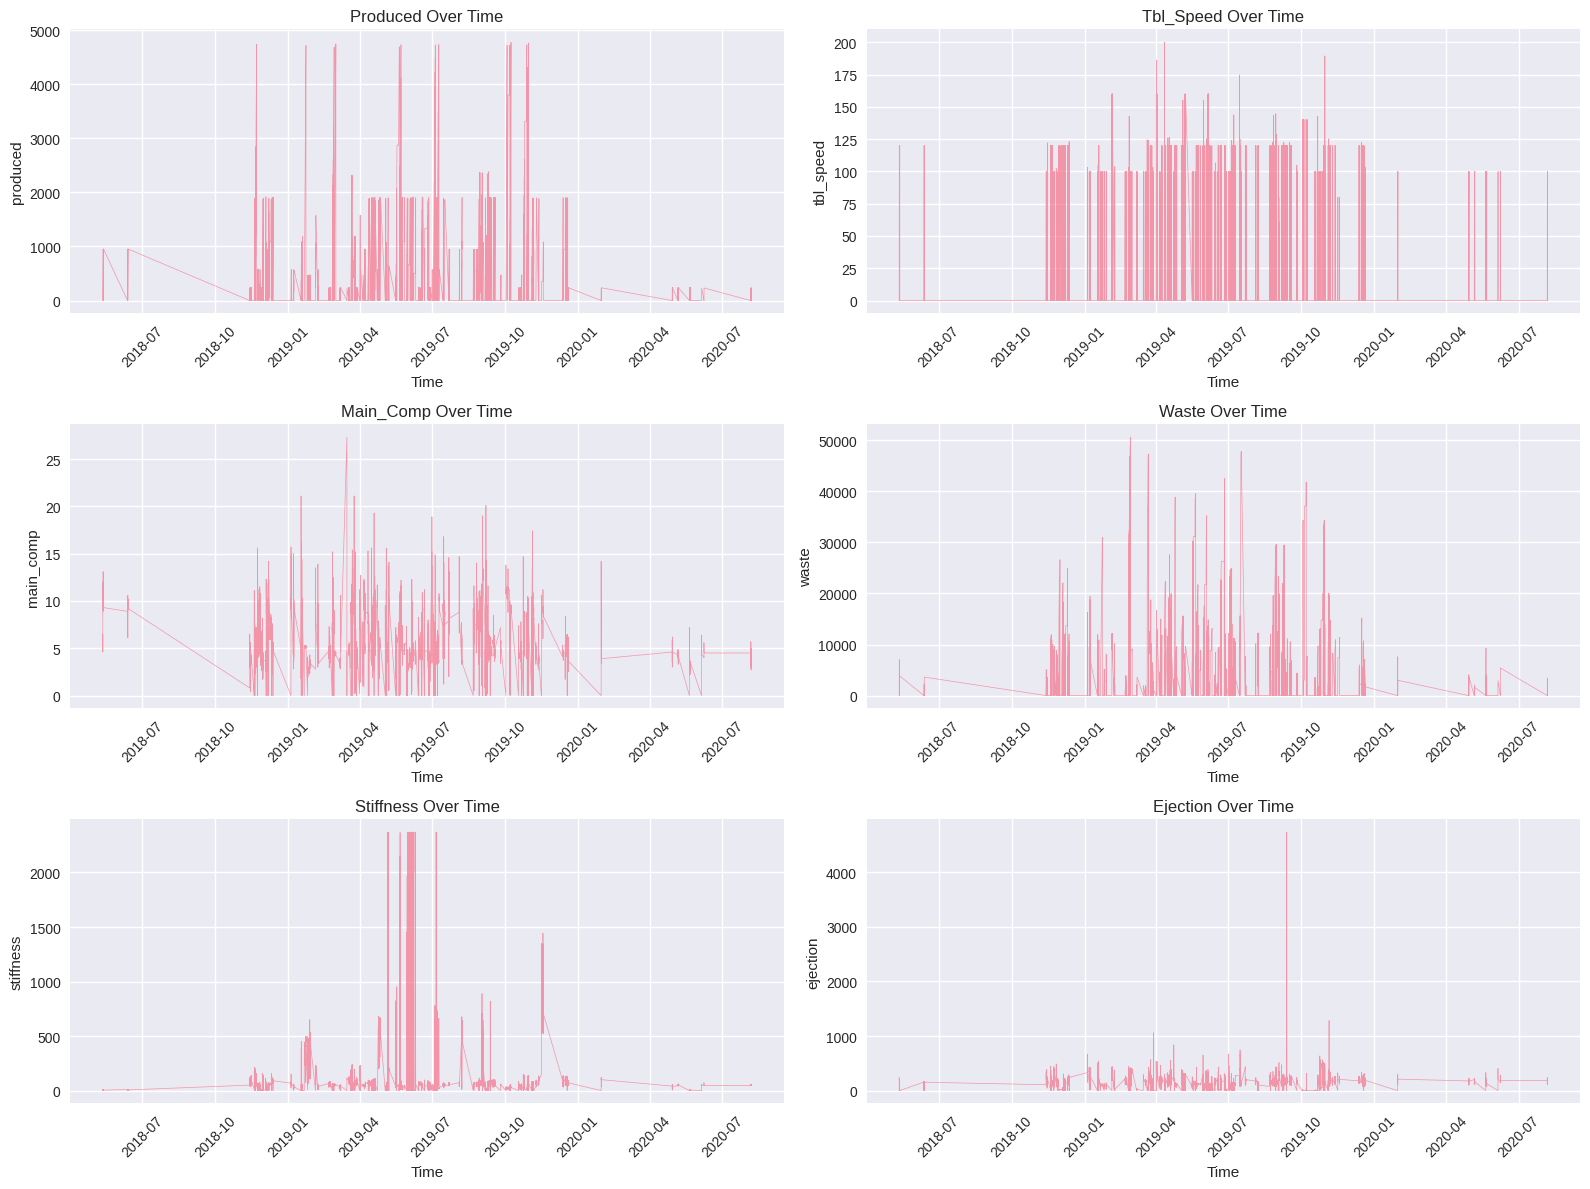

In [18]:
# Prepare key variables for time series analysis
key_variables = ['produced', 'tbl_speed', 'main_comp', 'waste', 'stiffness', 'ejection']

# Sort data by timestamp for time series analysis
combined_data_sorted = combined_data.sort_values('timestamp').reset_index(drop=True)

# 1. Overall time series visualization for key variables
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.ravel()

for i, var in enumerate(key_variables):
    axes[i].plot(combined_data_sorted['timestamp'], combined_data_sorted[var], alpha=0.7, linewidth=0.5)
    axes[i].set_title(f'{var.title()} Over Time')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# 2. Production analysis by file/campaign
print("Production Analysis by File/Campaign:")
production_summary = combined_data.groupby(['file_id', 'campaign']).agg({
    'produced': ['max', 'mean'],
    'waste': ['max', 'mean'],
    'timestamp': ['min', 'max']
}).round(2)

production_summary.columns = ['Max_Produced', 'Avg_Produced', 'Max_Waste', 'Avg_Waste', 'Start_Time', 'End_Time']
print(production_summary.head(10))

# 3. Production efficiency calculation
combined_data['production_efficiency'] = combined_data['produced'] / (combined_data['produced'] + combined_data['waste'] + 1e-10)
combined_data['production_efficiency'] = combined_data['production_efficiency'].fillna(0)


Production Analysis by File/Campaign:
                  Max_Produced  Avg_Produced  Max_Waste  Avg_Waste  \
file_id campaign                                                     
1       4                241.0         93.81     6740.0    2670.19   
        8                237.0         95.19     8030.0    2805.75   
        31               238.0         93.82    10181.0    3968.58   
        65               241.0         96.92     5711.0    2602.21   
        66               238.0         96.50     5441.0    2645.87   
        67               238.0         94.87     5311.0    2163.81   
        109              236.0         94.08     6726.0    2254.44   
2       5               1911.0        891.97    11946.0    7648.73   
        9               1919.0        899.12    26633.0   14680.88   
        41              1896.0        906.71    27596.0   18500.73   

                          Start_Time            End_Time  
file_id campaign                                          
1  

### Note The below cell takes time to run

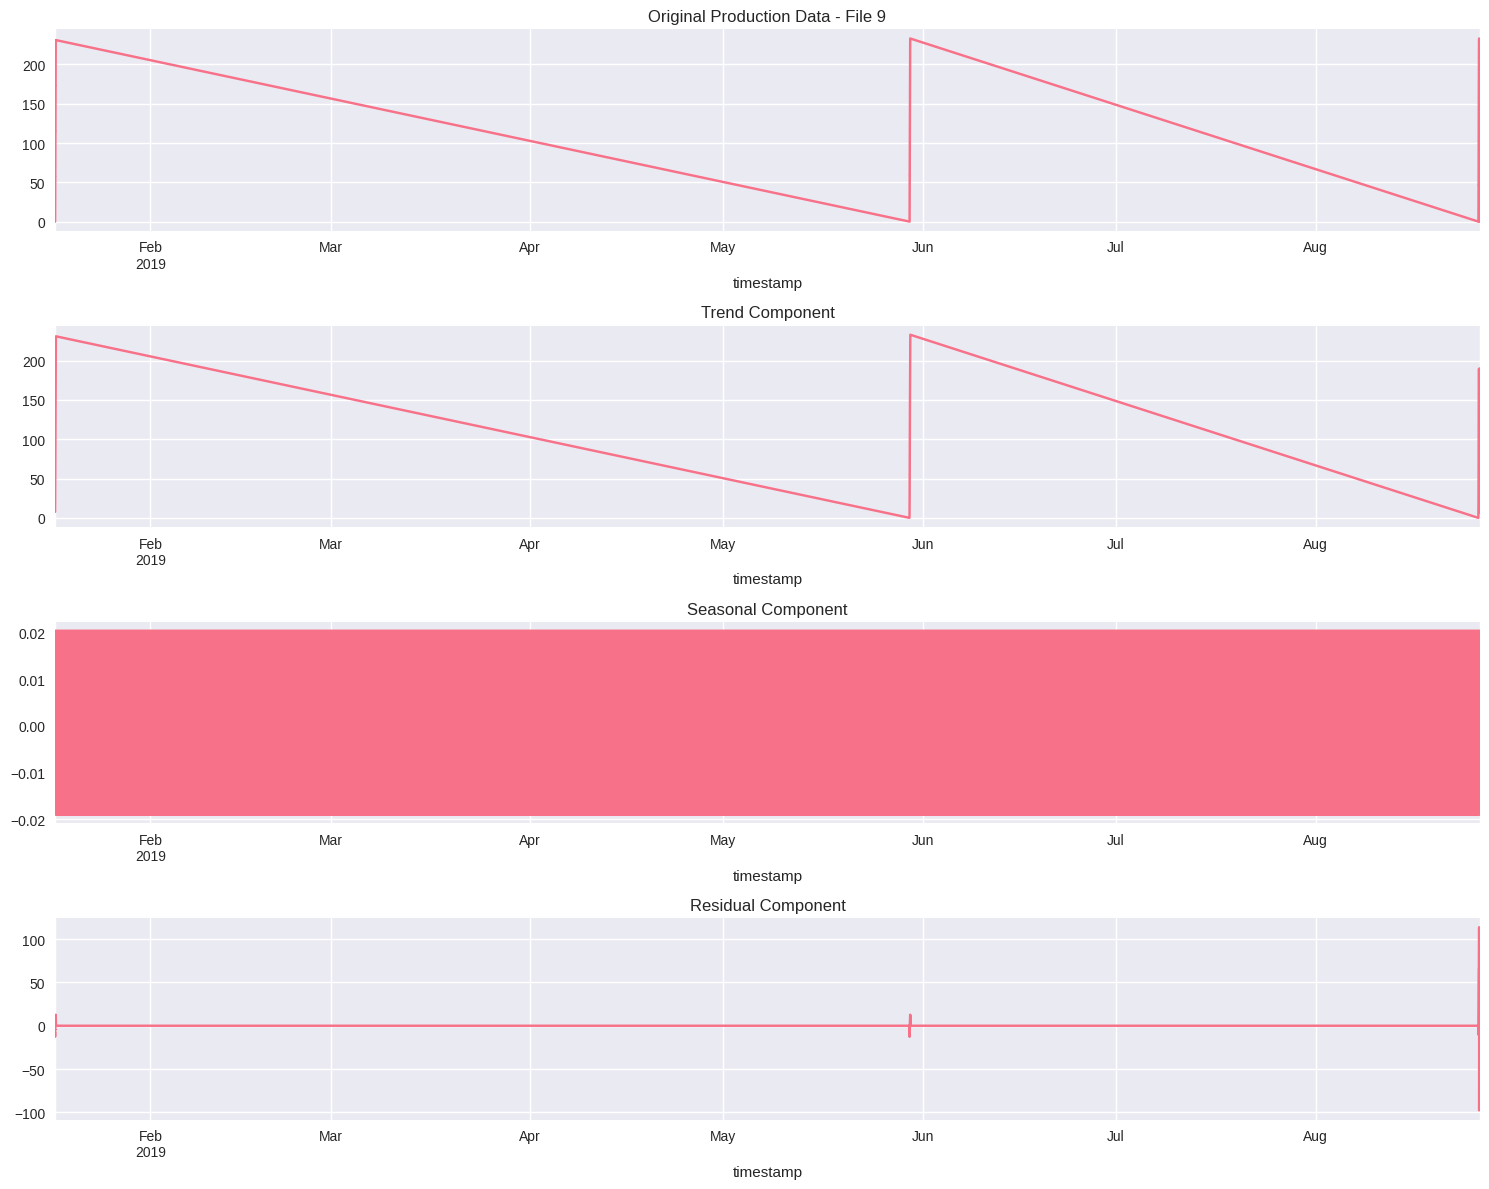

Time series decomposition completed for 3 processes


In [20]:
# Time series decomposition for production data
def analyze_single_process(file_id, variable='produced'):
    
    process_data = combined_data[combined_data['file_id'] == file_id].copy()
    process_data = process_data.sort_values('timestamp').reset_index(drop=True)
    
    if len(process_data) < 50:  # Skip if too few data points
        return None
    
    # Set timestamp as index for time series analysis
    process_data.set_index('timestamp', inplace=True)
    
    # Resample to ensure regular intervals (handle any gaps)
    process_data = process_data.resample('10S').mean().interpolate()
    
    # Time series decomposition
    try:
        if len(process_data) >= 100:  # Need sufficient data for decomposition
            decomposition = seasonal_decompose(process_data[variable], 
                                             model='additive', 
                                             period=360)  # 1 hour periods (360 * 10s = 1h)
            
            return {
                'file_id': file_id,
                'variable': variable,
                'trend': decomposition.trend,
                'seasonal': decomposition.seasonal,
                'residual': decomposition.resid,
                'original': process_data[variable]
            }
    except Exception as e:
        print(f"Decomposition failed for file {file_id}: {e}")
        return None

# Analyze a few representative processes
sample_files = [9, 18, 20]  # Based on files we examined earlier
decomposition_results = []

for file_id in sample_files:
    result = analyze_single_process(file_id, 'produced')
    if result:
        decomposition_results.append(result)

# Visualize decomposition for one process
if decomposition_results:
    result = decomposition_results[0]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    result['original'].plot(ax=axes[0], title=f'Original Production Data - File {result["file_id"]}')
    result['trend'].plot(ax=axes[1], title='Trend Component')
    result['seasonal'].plot(ax=axes[2], title='Seasonal Component')
    result['residual'].plot(ax=axes[3], title='Residual Component')
    
    plt.tight_layout()
    plt.show()

print(f"Time series decomposition completed for {len(decomposition_results)} processes")


## 4. Statistical Analysis and Distributions

The statistical properties and distributions of our key variables.


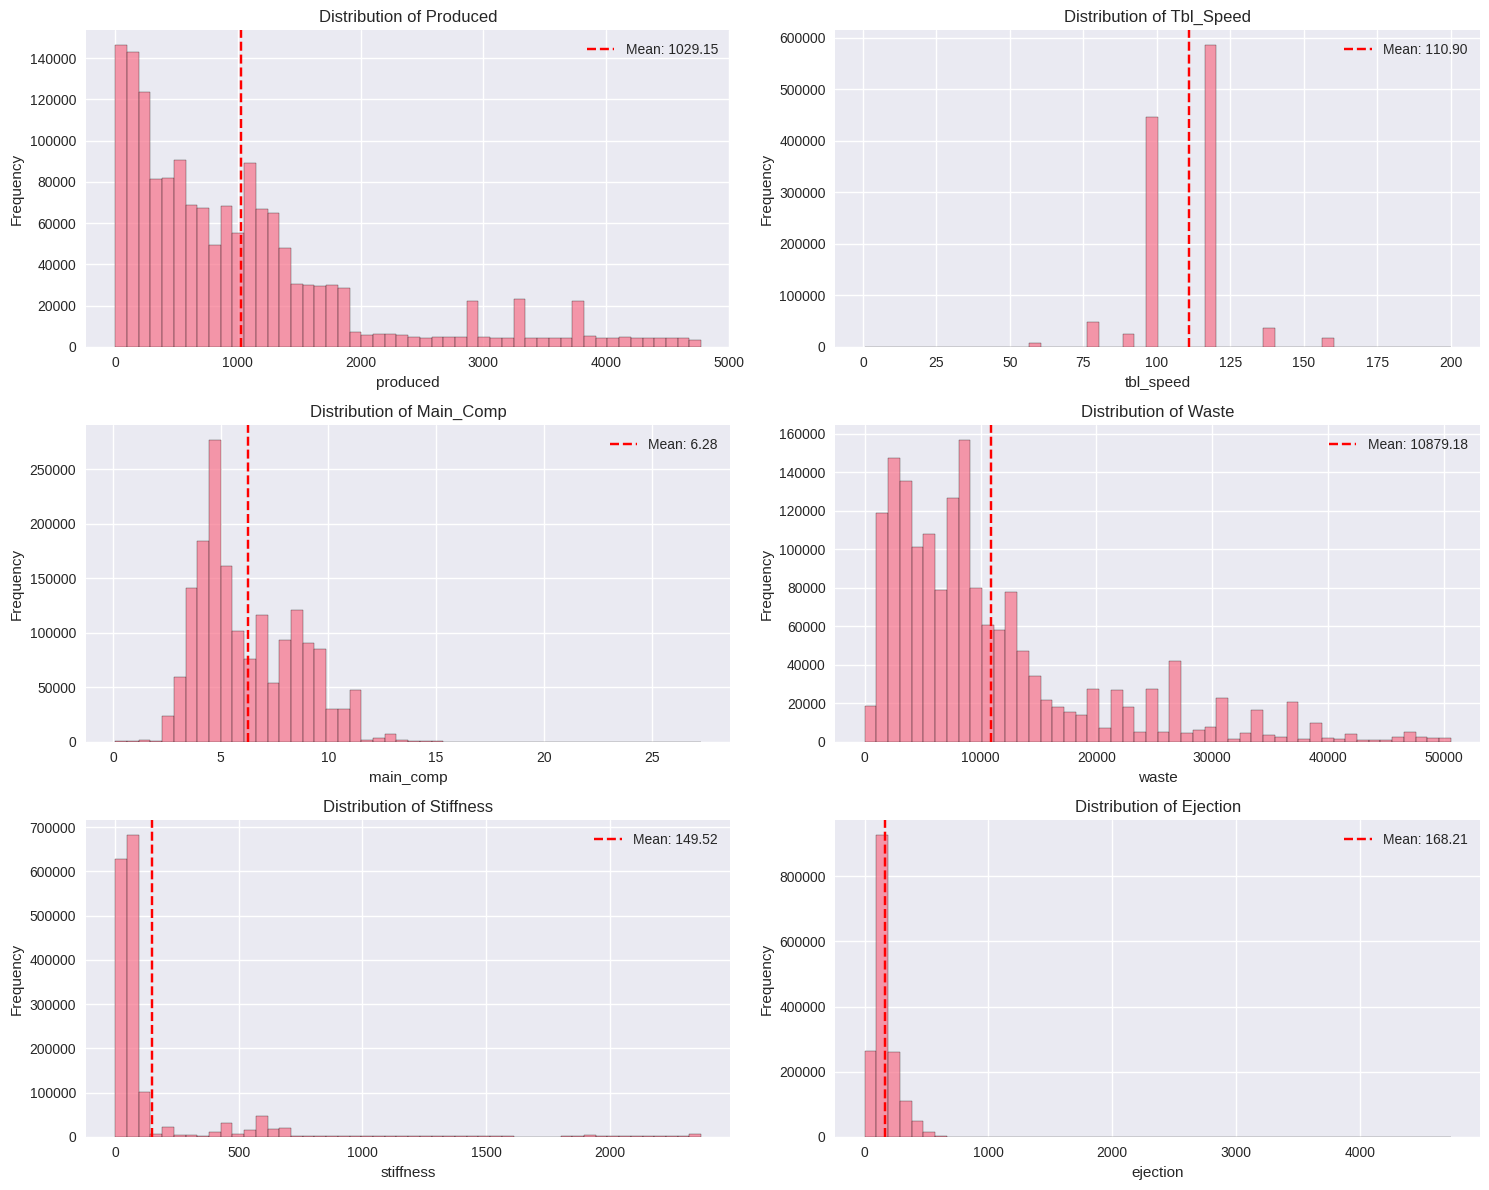

In [21]:
# 1. Distribution Analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, var in enumerate(key_variables):
    # Remove zeros for better visualization (many variables start at 0)
    data = combined_data[combined_data[var] > 0][var]
    
    axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {var.title()}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    
    # Add statistics text
    mean_val = data.mean()
    std_val = data.std()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Correlation Analysis:


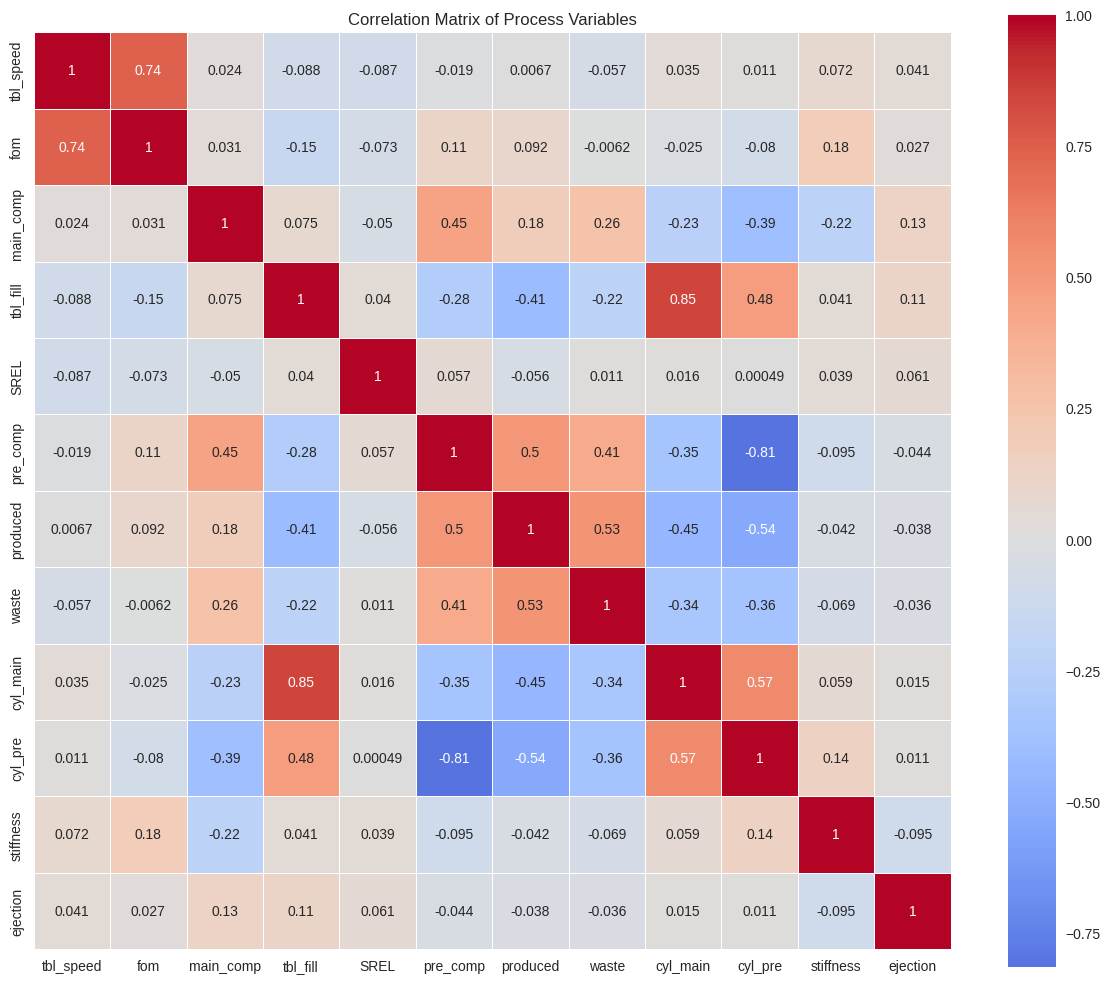

In [22]:
# 2. Correlation Analysis
print("Correlation Analysis:")
correlation_vars = ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 
                   'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']

correlation_matrix = combined_data[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Process Variables')
plt.tight_layout()
plt.show()


In [23]:
# 3. Key correlations with production
print("\nKey correlations with 'produced':")
prod_correlations = correlation_matrix['produced'].sort_values(key=abs, ascending=False)
for var, corr in prod_correlations.items():
    if var != 'produced':
        print(f"{var}: {corr:.3f}")


Key correlations with 'produced':
cyl_pre: -0.538
waste: 0.526
pre_comp: 0.505
cyl_main: -0.451
tbl_fill: -0.412
main_comp: 0.177
fom: 0.092
SREL: -0.056
stiffness: -0.042
ejection: -0.038
tbl_speed: 0.007


In [24]:
# 4. Outlier Detection using IQR method
print("\n\nOutlier Detection (IQR Method):")
outlier_summary = []

for var in key_variables:
    data = combined_data[var]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_summary.append({
        'variable': var,
        'total_outliers': len(outliers),
        'outlier_percentage': (len(outliers) / len(data)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)



Outlier Detection (IQR Method):
    variable  total_outliers  outlier_percentage  lower_bound  upper_bound
0   produced          116702            6.796162     -1493.50      3022.50
1  tbl_speed               0            0.000000      -180.00       300.00
2  main_comp            1510            0.087935        -1.05        13.75
3      waste          123667            7.201770     -9999.50     27396.50
4  stiffness          230690           13.434274       -37.00       147.00
5   ejection          120673            7.027414       -18.00       318.00


In [25]:
# 5. Production Rate Analysis
print("\n\nProduction Rate Analysis:")
# Calculate production rate per minute for each file
production_rates = []
for file_id in sorted(combined_data['file_id'].unique()):
    file_data = combined_data[combined_data['file_id'] == file_id].copy()
    file_data = file_data.sort_values('timestamp')
    
    if len(file_data) > 1:
        duration_minutes = (file_data['timestamp'].max() - file_data['timestamp'].min()).total_seconds() / 60
        total_produced = file_data['produced'].max() - file_data['produced'].min()
        production_rate = total_produced / duration_minutes if duration_minutes > 0 else 0
        
        production_rates.append({
            'file_id': file_id,
            'campaign': file_data['campaign'].iloc[0],
            'batch': file_data['batch'].iloc[0],
            'duration_hours': duration_minutes / 60,
            'total_produced': total_produced,
            'production_rate_per_min': production_rate,
            'max_tbl_speed': file_data['tbl_speed'].max(),
            'avg_tbl_speed': file_data['tbl_speed'].mean()
        })

production_rate_df = pd.DataFrame(production_rates)
print("Production Rate Summary:")
print(production_rate_df.describe())




Production Rate Analysis:
Production Rate Summary:
         file_id   campaign      batch  duration_hours  total_produced  \
count  21.000000  21.000000   21.00000       21.000000       21.000000   
mean   12.238095  20.428571   80.00000     6248.995410     1453.047619   
std     7.641366  16.642029   74.28728     3463.618434     1310.469934   
min     1.000000   3.000000    1.00000       18.319444      233.000000   
25%     6.000000  11.000000   38.00000     4450.074444      477.000000   
50%    11.000000  18.000000   77.00000     6633.521944     1090.000000   
75%    19.000000  24.000000   88.00000     8078.612500     1915.000000   
max    25.000000  80.000000  368.00000    13041.318333     4775.000000   

       production_rate_per_min  max_tbl_speed  avg_tbl_speed  
count                21.000000       21.00000      21.000000  
mean                  0.104639      125.52381      71.749419  
std                   0.379774       28.45665      18.636864  
min                   0.0003

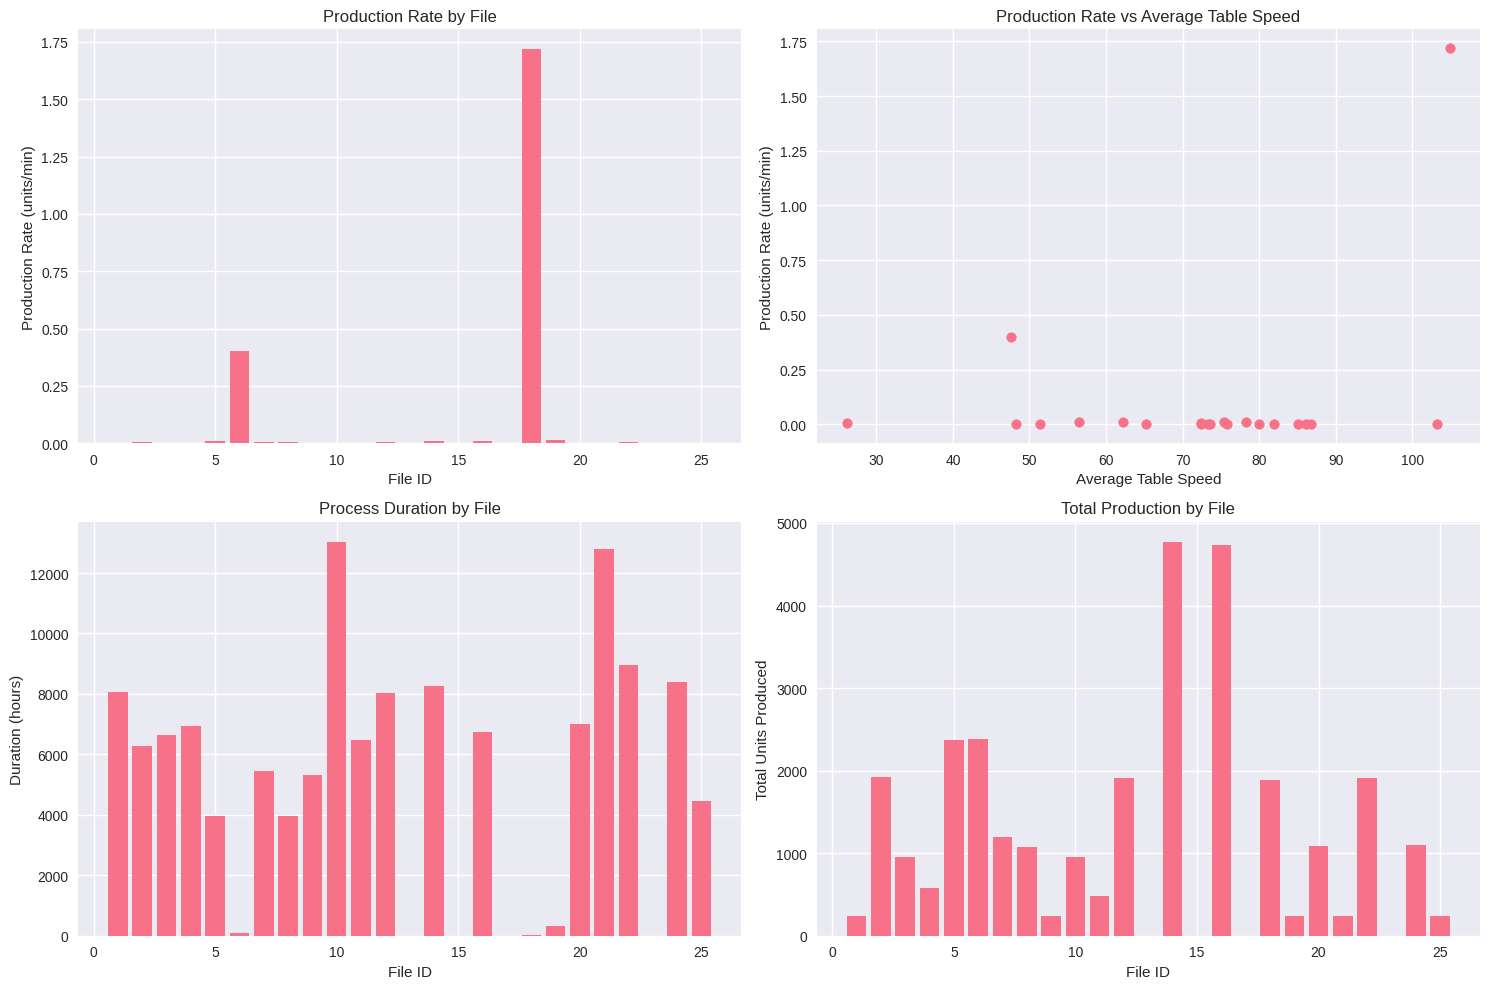

In [26]:
# Visualize production rates
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Production rate by file
axes[0,0].bar(production_rate_df['file_id'], production_rate_df['production_rate_per_min'])
axes[0,0].set_title('Production Rate by File')
axes[0,0].set_xlabel('File ID')
axes[0,0].set_ylabel('Production Rate (units/min)')

# Production rate vs table speed
axes[0,1].scatter(production_rate_df['avg_tbl_speed'], production_rate_df['production_rate_per_min'])
axes[0,1].set_title('Production Rate vs Average Table Speed')
axes[0,1].set_xlabel('Average Table Speed')
axes[0,1].set_ylabel('Production Rate (units/min)')

# Duration analysis
axes[1,0].bar(production_rate_df['file_id'], production_rate_df['duration_hours'])
axes[1,0].set_title('Process Duration by File')
axes[1,0].set_xlabel('File ID')
axes[1,0].set_ylabel('Duration (hours)')

# Total production by file
axes[1,1].bar(production_rate_df['file_id'], production_rate_df['total_produced'])
axes[1,1].set_title('Total Production by File')
axes[1,1].set_xlabel('File ID')
axes[1,1].set_ylabel('Total Units Produced')

plt.tight_layout()
plt.show()

## 5. Time Series Forecasting Preparation

This section focuses on preparing the data specifically for time series forecasting applications. We'll analyze stationarity, seasonality patterns, and create features that will be useful for forecasting models.


=== STATIONARITY ANALYSIS ===

--- File 9 ---

Stationarity Test for File 9 - Produced:
ADF Statistic: -2.374120
p-value: 0.149174
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

Stationarity Test for File 9 - Table Speed:
ADF Statistic: -3.630788
p-value: 0.005199
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✓ Series is stationary (reject null hypothesis)

Stationarity Test for File 9 - Main Component:
ADF Statistic: -2.202687
p-value: 0.205272
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

--- File 18 ---

Stationarity Test for File 18 - Produced:
ADF Statistic: -2.399189
p-value: 0.141965
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
✗ Series is non-stationary (fail to reject null hypothesis)

Stationarity Test for File 18 - Table Speed:
ADF Statistic: -3.794200
p-value: 0.002967
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


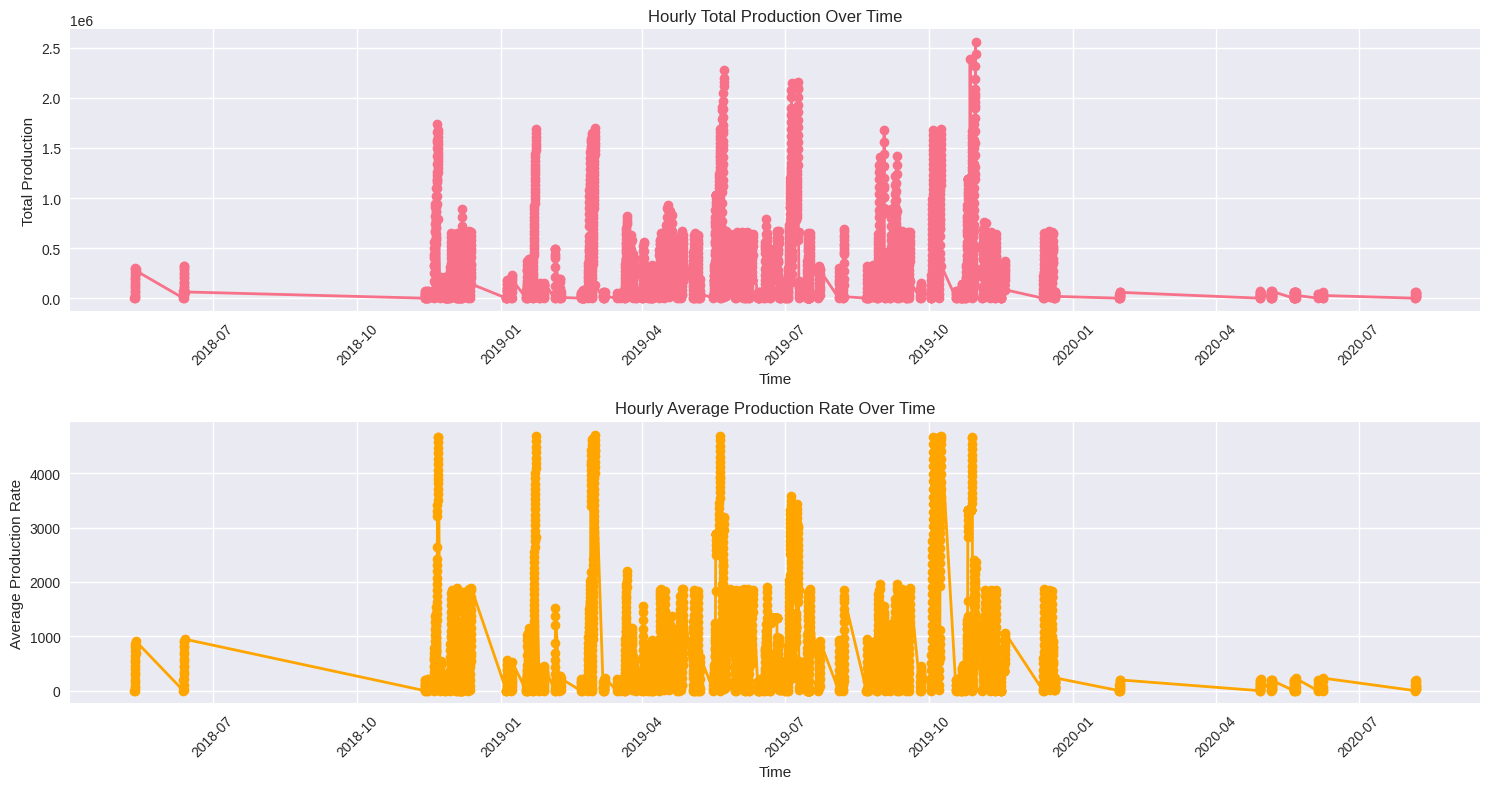


Hourly data date range: 2018-05-12 00:00:00 to 2020-08-06 12:00:00
Total hours of data: 3934
Average hourly production: 415524.90 units/hour


In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

def test_stationarity(series, series_name):
    """Test stationarity using Augmented Dickey-Fuller test"""
    print(f"\nStationarity Test for {series_name}:")
    
    # Remove NaN values
    series_clean = series.dropna()
    
    if len(series_clean) < 10:
        print("Not enough data for stationarity test")
        return
    
    # Perform ADF test
    result = adfuller(series_clean)
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")

# Test stationarity for key production variables
print("=== STATIONARITY ANALYSIS ===")

# For each file, test stationarity of key variables
stationarity_results = []

for file_id in [9, 18, 20]:  # Test on sample files
    print(f"\n--- File {file_id} ---")
    file_data = combined_data[combined_data['file_id'] == file_id].copy()
    file_data = file_data.sort_values('timestamp').reset_index(drop=True)
    
    # Test production data
    if len(file_data) > 50:
        test_stationarity(file_data['produced'], f"File {file_id} - Produced")
        test_stationarity(file_data['tbl_speed'], f"File {file_id} - Table Speed")
        test_stationarity(file_data['main_comp'], f"File {file_id} - Main Component")

# 2. Create aggregated time series for forecasting
print("\n\n=== CREATING AGGREGATED TIME SERIES ===")

# Aggregate data by hour for forecasting
def create_hourly_aggregation():
    """Create hourly aggregated data for time series forecasting"""
    
    # Add hour column
    combined_data['hour'] = combined_data['timestamp'].dt.floor('H')
    
    # Aggregate by hour
    hourly_data = combined_data.groupby('hour').agg({
        'produced': ['sum', 'mean', 'max'],
        'waste': ['sum', 'mean'],
        'tbl_speed': ['mean', 'max'],
        'main_comp': ['mean', 'std'],
        'stiffness': ['mean', 'std'],
        'ejection': ['mean', 'max'],
        'file_id': 'nunique',  # Number of active processes
        'campaign': 'nunique'
    }).round(2)
    
    # Flatten column names
    hourly_data.columns = ['_'.join(col).strip() for col in hourly_data.columns]
    hourly_data = hourly_data.reset_index()
    
    return hourly_data

hourly_data = create_hourly_aggregation()
print(f"Hourly aggregated data shape: {hourly_data.shape}")
print("\nFirst 5 rows of hourly data:")
print(hourly_data.head())

# Visualize hourly production trends
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(hourly_data['hour'], hourly_data['produced_sum'], marker='o', linewidth=2)
plt.title('Hourly Total Production Over Time')
plt.xlabel('Time')
plt.ylabel('Total Production')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.plot(hourly_data['hour'], hourly_data['produced_mean'], marker='o', linewidth=2, color='orange')
plt.title('Hourly Average Production Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Average Production Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nHourly data date range: {hourly_data['hour'].min()} to {hourly_data['hour'].max()}")
print(f"Total hours of data: {len(hourly_data)}")
print(f"Average hourly production: {hourly_data['produced_sum'].mean():.2f} units/hour")


Feature engineered data shape: (3934, 47)
Number of features created: 31

Top 15 features correlated with production:
produced_sum                    1.000000
produced_sum_rolling_min_3      0.992511
produced_sum_rolling_mean_3     0.969496
produced_sum_rolling_min_6      0.965644
produced_sum_lag_1              0.951406
produced_max                    0.939621
produced_sum_rolling_mean_6     0.912414
produced_sum_rolling_max_3      0.909526
produced_sum_lag_2              0.889018
produced_sum_rolling_min_12     0.884765
produced_mean                   0.877996
produced_sum_lag_3              0.830892
produced_sum_rolling_mean_12    0.823591
produced_sum_rolling_max_6      0.793307
produced_sum_rolling_min_24     0.737904
Name: produced_sum, dtype: float64


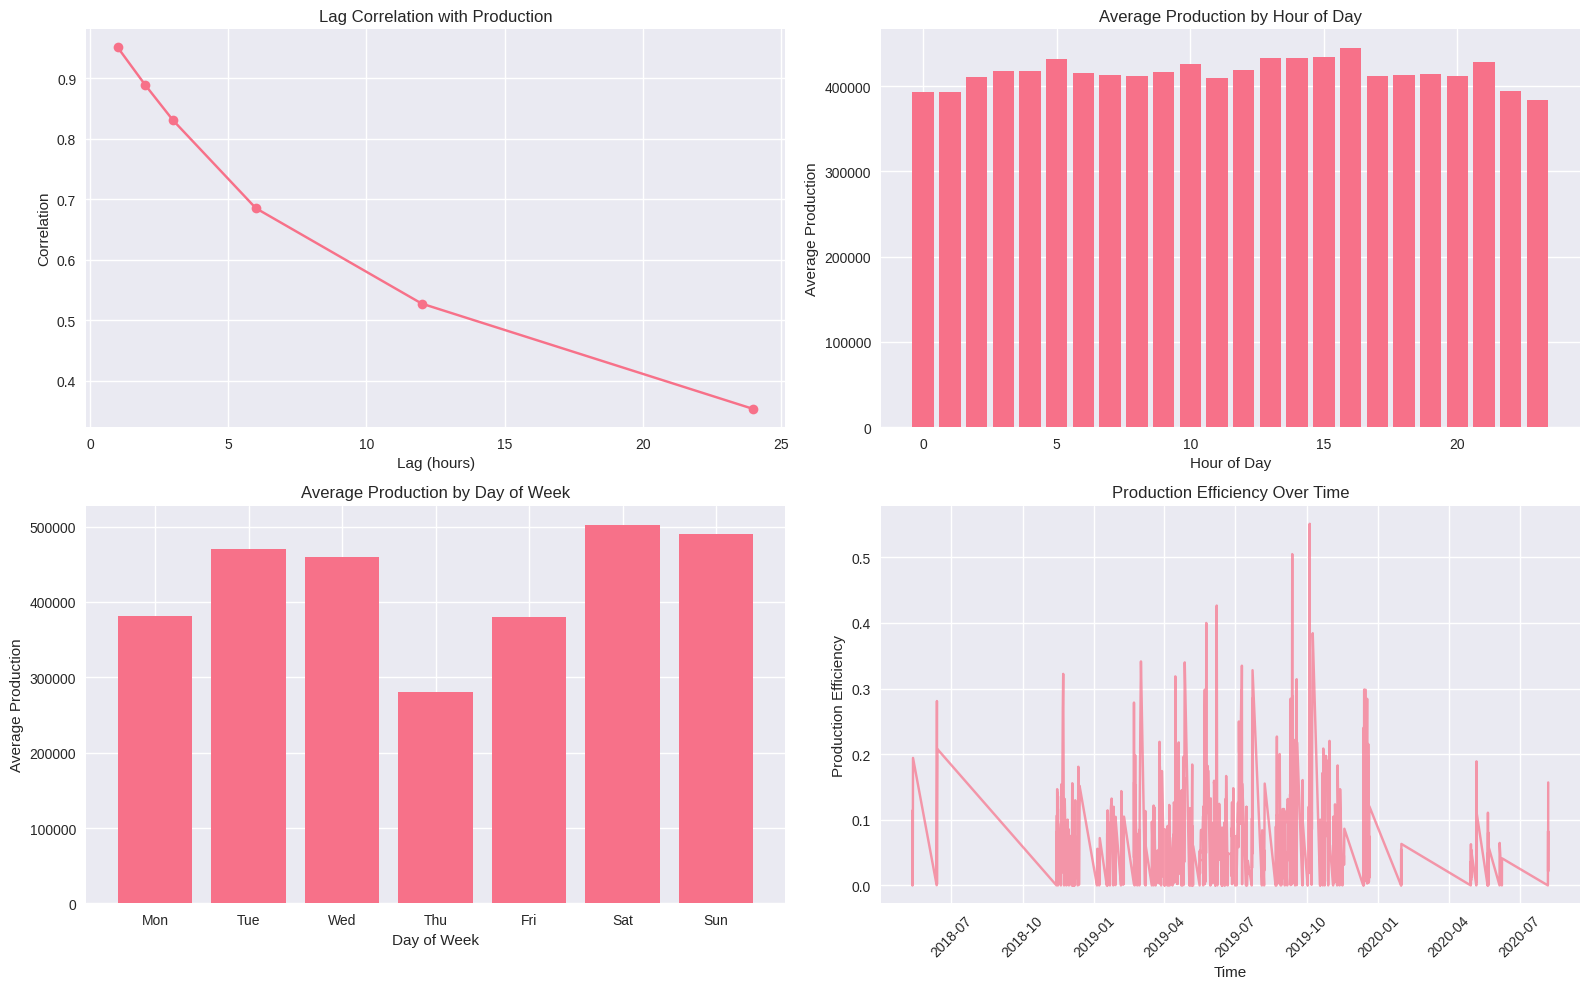


Saving processed data for forecasting...
Data saved as 'hourly_production_features.csv'


In [28]:
# 3. Advanced Time Series Feature Engineering

def create_forecasting_features(df, target_col='produced_sum'):
    
    # Sort by time
    df = df.sort_values('hour').copy()
    
    # Create lag features
    for lag in [1, 2, 3, 6, 12, 24]:  # 1h, 2h, 3h, 6h, 12h, 24h lags
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12, 24]:  # 3h, 6h, 12h, 24h windows
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'{target_col}_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
        df[f'{target_col}_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
    
    # Time-based features
    df['hour_of_day'] = df['hour'].dt.hour
    df['day_of_week'] = df['hour'].dt.dayofweek
    df['day_of_month'] = df['hour'].dt.day
    df['month'] = df['hour'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Difference features (for trend analysis)
    df[f'{target_col}_diff_1'] = df[target_col].diff(1)
    df[f'{target_col}_diff_24'] = df[target_col].diff(24)  # 24-hour difference
    
    # Production efficiency features
    df['production_efficiency'] = df['produced_sum'] / (df['produced_sum'] + df['waste_sum'] + 1e-10)
    df['waste_ratio'] = df['waste_sum'] / (df['produced_sum'] + 1e-10)
    
    return df

# Apply feature engineering
hourly_features = create_forecasting_features(hourly_data.copy())
print(f"Feature engineered data shape: {hourly_features.shape}")
print(f"Number of features created: {hourly_features.shape[1] - hourly_data.shape[1]}")

# Display correlation with target variable
target_correlations = hourly_features.corr()['produced_sum'].sort_values(key=abs, ascending=False)
print("\nTop 15 features correlated with production:")
print(target_correlations.head(15))

# Visualize some key features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Lag correlation plot
lag_cols = [col for col in hourly_features.columns if 'produced_sum_lag_' in col]
lag_corrs = [hourly_features[col].corr(hourly_features['produced_sum']) for col in lag_cols]
lag_nums = [int(col.split('_')[-1]) for col in lag_cols]

axes[0,0].plot(lag_nums, lag_corrs, marker='o')
axes[0,0].set_title('Lag Correlation with Production')
axes[0,0].set_xlabel('Lag (hours)')
axes[0,0].set_ylabel('Correlation')
axes[0,0].grid(True)

# Hour of day pattern
hourly_prod_pattern = hourly_features.groupby('hour_of_day')['produced_sum'].mean()
axes[0,1].bar(hourly_prod_pattern.index, hourly_prod_pattern.values)
axes[0,1].set_title('Average Production by Hour of Day')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Production')

# Day of week pattern
daily_prod_pattern = hourly_features.groupby('day_of_week')['produced_sum'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(range(7), daily_prod_pattern.values)
axes[1,0].set_title('Average Production by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Average Production')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(day_names)

# Production efficiency over time
axes[1,1].plot(hourly_features['hour'], hourly_features['production_efficiency'], alpha=0.7)
axes[1,1].set_title('Production Efficiency Over Time')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Production Efficiency')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save processed data for forecasting
print(f"\nSaving processed data for forecasting...")
hourly_features.to_csv('hourly_production_features.csv', index=False)
print("Data saved as 'hourly_production_features.csv'")


## 6. Summary and Forecasting Recommendations


In [30]:
# Data Summary
print("\n1. DATASET OVERVIEW:")
print(f"   • Total Records: {len(combined_data):,}")
print(f"   • Number of Manufacturing Campaigns: {combined_data['campaign'].nunique()}")
print(f"   • Number of Process Files: {combined_data['file_id'].nunique()}")
print(f"   • Date Range: {combined_data['timestamp'].min()} to {combined_data['timestamp'].max()}")
print(f"   • Total Duration: {(combined_data['timestamp'].max() - combined_data['timestamp'].min()).days} days")

# Production Statistics
total_production = combined_data.groupby('file_id')['produced'].max().sum()
total_waste = combined_data.groupby('file_id')['waste'].max().sum()
overall_efficiency = total_production / (total_production + total_waste) * 100

print(f"\n2. PRODUCTION METRICS:")
print(f"   • Total Units Produced: {total_production:,}")
print(f"   • Total Waste Generated: {total_waste:,}")
print(f"   • Overall Production Efficiency: {overall_efficiency:.2f}%")
print(f"   • Average Production Rate: {production_rate_df['production_rate_per_min'].mean():.2f} units/min")

# Data Quality Assessment
missing_percentage = (combined_data.isnull().sum().sum() / (len(combined_data) * len(combined_data.columns))) * 100
print(f"\n3. DATA QUALITY:")
print(f"   • Data Completeness: {100-missing_percentage:.2f}%")
print(f"   • Missing Values: {combined_data.isnull().sum().sum():,}")
print(f"   • Duplicate Records: {combined_data.duplicated().sum():,}")

# Process Insights
print(f"\n4. PROCESS INSIGHTS:")
print(f"   • Number of Different Process Codes: {combined_data['code'].nunique()}")
print(f"   • Average Table Speed: {combined_data['tbl_speed'].mean():.2f}")
print(f"   • Production Variability: {combined_data['produced'].std():.2f} (std dev)")



1. DATASET OVERVIEW:
   • Total Records: 1,717,175
   • Number of Manufacturing Campaigns: 93
   • Number of Process Files: 21
   • Date Range: 2018-05-12 00:22:52 to 2020-08-06 12:47:44
   • Total Duration: 817 days

2. PRODUCTION METRICS:
   • Total Units Produced: 30,514.0
   • Total Waste Generated: 483,410.0
   • Overall Production Efficiency: 5.94%
   • Average Production Rate: 0.10 units/min

3. DATA QUALITY:
   • Data Completeness: 99.96%
   • Missing Values: 13,706
   • Duplicate Records: 360

4. PROCESS INSIGHTS:
   • Number of Different Process Codes: 21
   • Average Table Speed: 75.19
   • Production Variability: 1006.42 (std dev)


In [31]:
summary_stats = {
    'Metric': [
        'Total Records', 'Total Production', 'Total Waste', 'Production Efficiency %', 
        'Average Production Rate (units/min)', 'Data Completeness %', 'Number of Files',
        'Date Range (days)', 'Hourly Data Points'
    ],
    'Value': [
        f"{len(combined_data):,}",
        f"{total_production:,}",
        f"{total_waste:,}",
        f"{overall_efficiency:.2f}%",
        f"{production_rate_df['production_rate_per_min'].mean():.2f}",
        f"{100-missing_percentage:.2f}%",
        f"{combined_data['file_id'].nunique()}",
        f"{(combined_data['timestamp'].max() - combined_data['timestamp'].min()).days}",
        f"{len(hourly_data)}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\nSUMMARY STATISTICS TABLE:")
print(summary_df.to_string(index=False))

# Save summary for reference
summary_df.to_csv('eda_summary_statistics.csv', index=False)
print(f"\nSummary statistics saved to 'eda_summary_statistics.csv'")
print(f"Feature engineered dataset saved to 'hourly_production_features.csv'")


SUMMARY STATISTICS TABLE:
                             Metric     Value
                      Total Records 1,717,175
                   Total Production  30,514.0
                        Total Waste 483,410.0
            Production Efficiency %     5.94%
Average Production Rate (units/min)      0.10
                Data Completeness %    99.96%
                    Number of Files        21
                  Date Range (days)       817
                 Hourly Data Points      3934

Summary statistics saved to 'eda_summary_statistics.csv'
Feature engineered dataset saved to 'hourly_production_features.csv'
